In [12]:
import torch
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Load the image and preprocess
img = torchvision.io.read_image('road-8284023_1280.jpg')
img = img.float()  # Convert to float
img = img.mean(dim=0, keepdim=False)  # Convert to grayscale
img = torchvision.transforms.functional.crop(img, 800, 100, 300, 300)
img /= 255.0  # Normalize

# Parameters
patch_size = 50
stride = patch_size  # Non-overlapping patches
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def extract_patches(image, patch_size, stride):
    patches = []
    for i in range(0, image.shape[0] - patch_size + 1, stride):
        for j in range(0, image.shape[1] - patch_size + 1, stride):
            patch = image[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    return patches

def combine_patches(patches, img_shape, patch_size, stride):
    reconstructed_img = torch.zeros(img_shape)
    count = torch.zeros(img_shape)
    
    idx = 0
    for i in range(0, img_shape[0] - patch_size + 1, stride):
        for j in range(0, img_shape[1] - patch_size + 1, stride):
            patch = patches[idx]
            reconstructed_img[i:i+patch_size, j:j+patch_size] += patch
            count[i:i+patch_size, j:j+patch_size] += 1
            idx += 1
    
    return reconstructed_img / count

def matrix_factorization(A, k, device=torch.device("cpu"), epsilon=0.001):
    """Factorize the matrix A into W and H"""
    A = A.to(device)
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    epoch = 0
    prev_loss = float('inf')
    while True:
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch += 1
        if prev_loss - loss < epsilon:
            break
        prev_loss = loss

    return W, H, loss

def compute_rmse(tensor1, tensor2):
    assert tensor1.shape == tensor2.shape, "Tensors must have the same shape"
    mse = torch.mean((tensor1 - tensor2) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

def compute_psnr(tensor1, tensor2, max_pixel_value=1.0):
    mse = torch.mean((tensor1 - tensor2) ** 2)
    psnr = 10 * torch.log10(max_pixel_value ** 2 / mse)
    return psnr.item()

def mask_image(img, prop):
    img_copy = img.clone()
    mask = torch.rand(img.shape) < prop
    img_copy[mask] = float('nan')
    return img_copy, mask

def plot_image_completion(original_img, patches, patch_size, stride, factors):
    reconstructed_patches = []
    masked_patches = []
    for patch in patches:
        masked_patch, _ = mask_image(patch, 0)
        masked_patches.append(masked_patch)
        W, H, _ = matrix_factorization(masked_patch, factors, device=device)
        reconstructed_patch = torch.mm(W, H).cpu().detach()
        reconstructed_patches.append(reconstructed_patch)

    masked_image = combine_patches(masked_patches, original_img.shape, patch_size, stride)
    reconstructed_img = combine_patches(reconstructed_patches, original_img.shape, patch_size, stride)
    original_img = original_img.cpu().detach()

    # plt.figure(figsize=(8, 5))
    # plt.subplot(1, 2, 1)
    # plt.imshow(original_img, cmap='gray')
    # plt.title("Original Image")

    # plt.subplot(1, 2, 2)
    # plt.imshow(reconstructed_img, cmap='gray')
    # plt.title("Reconstructed Image")

    # plt.suptitle(f'Factors: {factors}')
    # plt.show()
    return masked_patches,reconstructed_patches

# Extract patches from the image
patches = extract_patches(img, patch_size, stride)

# Test for different values of rank r
for r in [5, 10, 25, 50]:
    _,_ = plot_image_completion(img, patches, patch_size, stride, r)


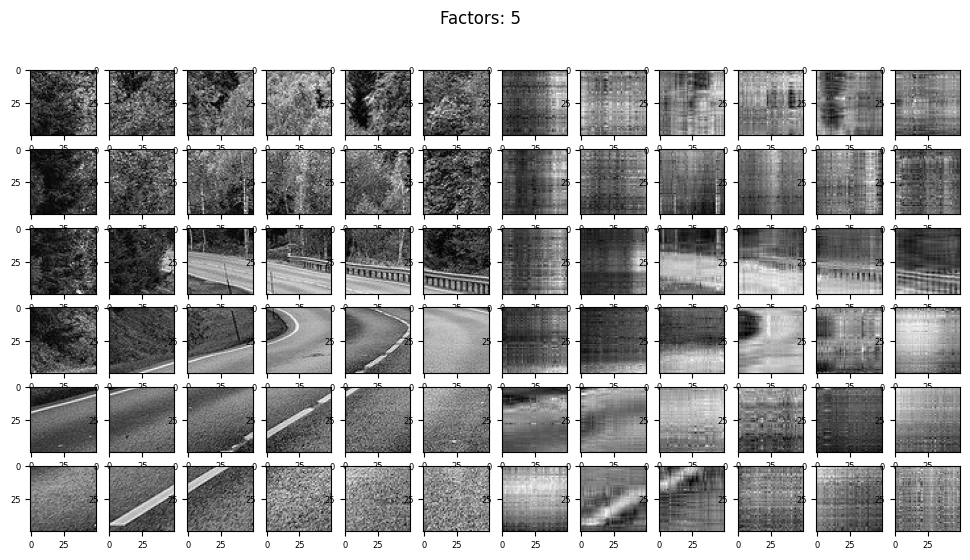

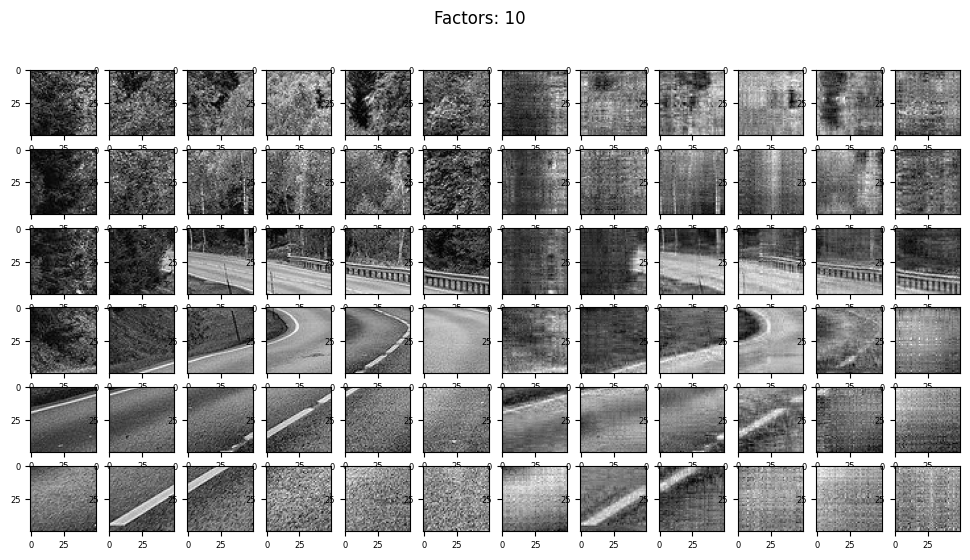

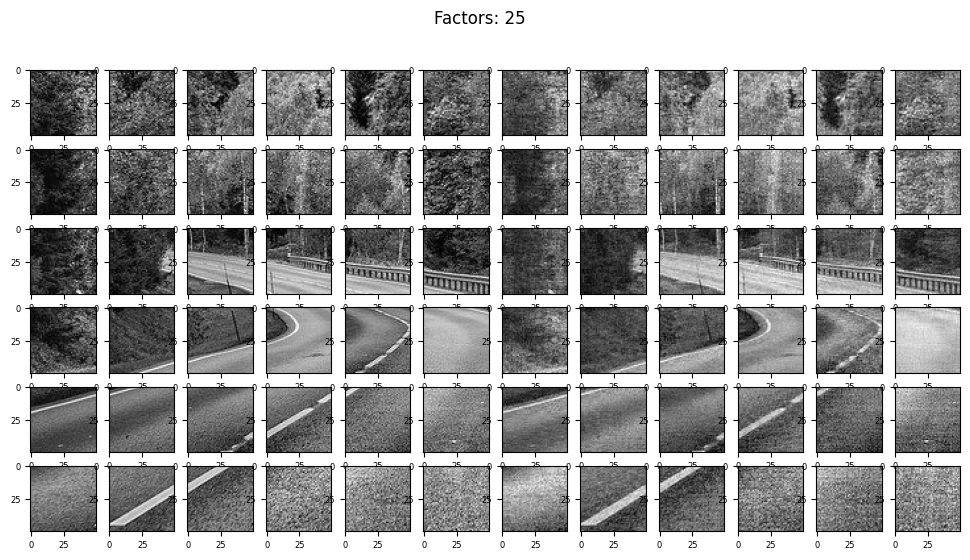

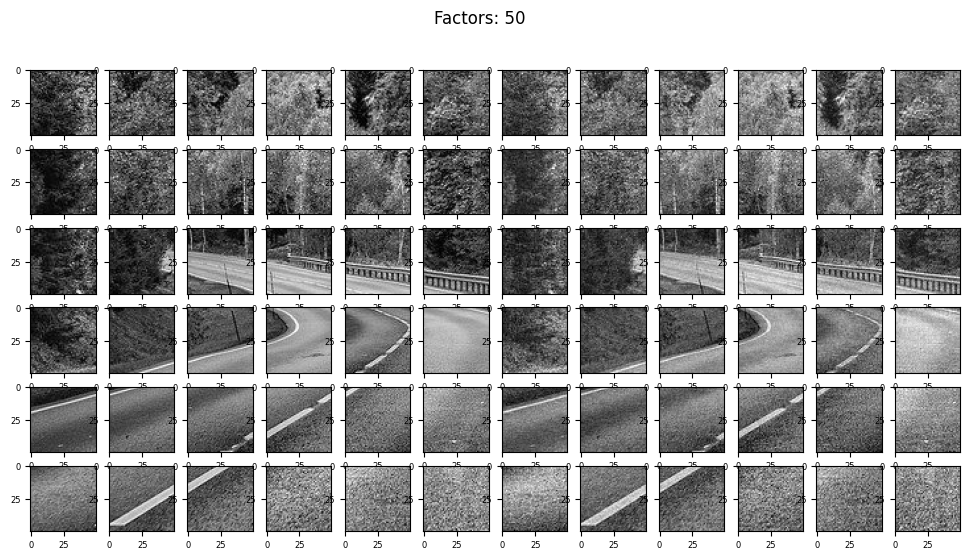

In [20]:
for r in [5, 10, 25, 50]:
    mask_patches,reconstructed_patches = plot_image_completion(img, patches, patch_size, stride, r)
    cnt_p = 0
    cnt_r = 0
    cnt = 1
    plt.figure(figsize=(12, 6))
    for i in range(1,7):
        for j in range(1,7):
            plt.subplot(6, 12, cnt)
            plt.xticks(fontsize=6)
            plt.yticks(fontsize=6)
            plt.imshow(patches[cnt_p].cpu().detach().numpy(), cmap='gray') 
            cnt +=1
            cnt_p+=1
        for j in range(1,7):
            plt.subplot(6, 12, cnt)
            plt.xticks(fontsize=6)
            plt.yticks(fontsize=6)
            plt.imshow(reconstructed_patches[cnt_r].cpu().detach().numpy(), cmap='gray') 
            cnt +=1
            cnt_r += 1
    plt.suptitle(f'Factors: {r}')
    plt.show()

        



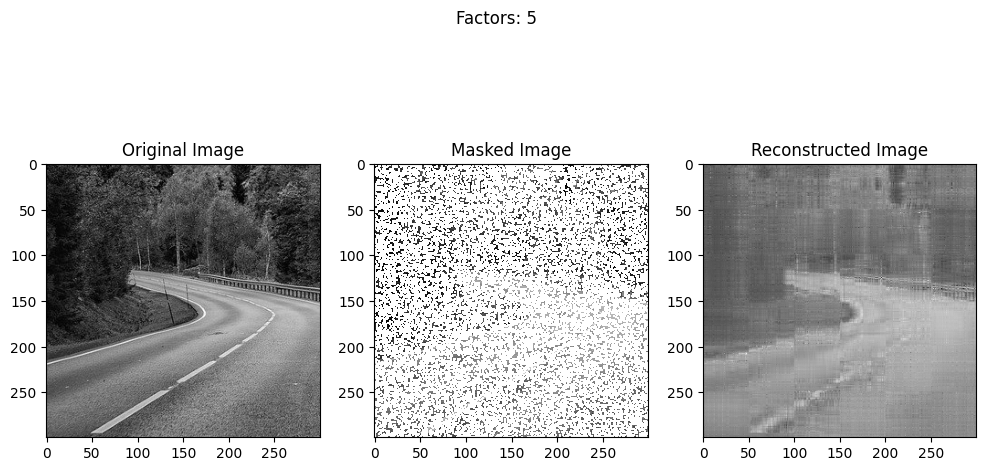

TypeError: cannot unpack non-iterable NoneType object

In [29]:
mask_patches,reconstructed_patches = plot_image_completion(img, patches, patch_size, stride, r)